In [1]:
import numpy as np;
import nibabel as nb;
import glob
import matplotlib.pyplot as plt
from loguru import logger

In [2]:
def min_max_normalization(image):
        image = (image - image.min()) / (image.max() - image.min()) * 255
        return image

In [11]:

import numpy as np
import matplotlib.pyplot as plt

def plot_random_brain_layers(prob_cfs_matter, prob_gray_matter, prob_white_matter, prob_bk):
    # Determine the number of layers available
    num_layers = prob_cfs_matter.shape[2]
    
    # Generate 5 unique random layers
    random_layers = np.random.choice(range(num_layers), size=5, replace=False)
    
    # Create a figure with 5 rows and 4 columns
    fig, axs = plt.subplots(5, 4, figsize=(20, 25))  # Adjust the size as needed

    for i, brain_layer in enumerate(random_layers):
        # Plot CSF matter for the current layer
        axs[i, 0].imshow(prob_cfs_matter[:, :, brain_layer])
        axs[i, 0].set_yticks([])
        axs[i, 0].set_xticks([])
        axs[i, 0].set_title(f'CSF Matter Layer {brain_layer}')

        # Plot gray matter for the current layer
        axs[i, 1].imshow(prob_gray_matter[:, :, brain_layer])
        axs[i, 1].set_yticks([])
        axs[i, 1].set_xticks([])
        axs[i, 1].set_title(f'Gray Matter Layer {brain_layer}')

        # Plot white matter for the current layer
        axs[i, 2].imshow(prob_white_matter[:, :, brain_layer])
        axs[i, 2].set_yticks([])
        axs[i, 2].set_xticks([])
        axs[i, 2].set_title(f'White Matter Layer {brain_layer}')

        # Plot background for the current layer
        axs[i, 3].imshow(prob_bk[:, :, brain_layer])
        axs[i, 3].set_yticks([])
        axs[i, 3].set_xticks([])
        axs[i, 3].set_title(f'Background Layer {brain_layer}')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()



## Getting images from labels and patients folder

In [4]:
root_dir = '../../data_lab2/'

patients = glob.glob(root_dir+ 'patients/' + '*.nii.gz')

labels = glob.glob(root_dir + 'labels/'+ '*.nii.gz')

masks = glob.glob(root_dir + 'masks/' + '*.nii.gz')

original = glob.glob(root_dir + 'original/' + '*.nii.gz')

original_labels = glob.glob(root_dir + 'Labels_original/' + '*.nii.gz')

logger.success(f'Imported from folder {len(original)}')

brain_layer = 127
number_of_brains = 5
brain_to_graph = 0


patients =  [ nb.load(patients[i]).get_fdata() for i in range(number_of_brains) ]

patients = [ min_max_normalization(patients[i]) for i in range(number_of_brains)]

labels =  [ nb.load (labels[i]).get_fdata() for i in range(number_of_brains) ]

masks =  [ nb.load (masks[i]).get_fdata() for i in range(number_of_brains) ]

original =  [ nb.load (original[i]).get_fdata() for i in range(number_of_brains) ]

original_labels =  [ nb.load (original_labels[i]).get_fdata() for i in range(number_of_brains) ]

patients = np.stack(patients,axis=0)
labels = np.stack(labels,axis=0)
masks = np.stack(masks,axis=0)


patients = patients * masks


logger.success(f'Size of the images arrays {labels.shape,masks.shape,labels.shape}')


2023-11-07 13:04:27.248 | SUCCESS  | __main__:<module>:13 - Imported from folder 15
2023-11-07 13:04:40.225 | SUCCESS  | __main__:<module>:40 - Size of the images arrays ((5, 256, 261, 256), (5, 256, 261, 256), (5, 256, 261, 256))


## Creating the MEAN MAP

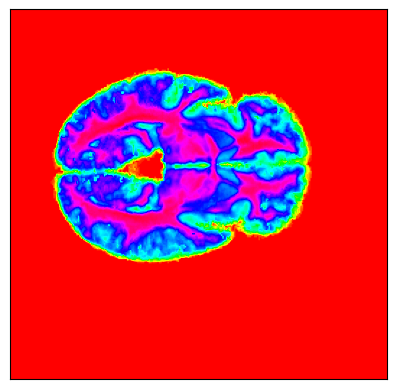

In [12]:
mean_map = np.mean(patients, axis=0)

plt.imshow(mean_map[:,:,brain_layer],cmap='hsv')
plt.yticks([])
plt.xticks([])
plt.show()

#File saving
nii_img = nb.Nifti1Image(mean_map, None)

# Specify the output file path with the .nii.gz extension
output_file = 'mean_map.nii.gz'

# Save the NIfTI image to a file
nii_img.to_filename(output_file)


In [6]:
white_matter_mask =  [ np.where(labels[i,:,:,:] == 3, 1, 0) for i in range(number_of_brains) ]
white_matter_mask = np.stack(white_matter_mask,axis=0)
white_matter = patients * white_matter_mask
prob_white_matter = np.sum(white_matter,axis=0)
prob_white_matter = ((prob_white_matter / np.max(prob_white_matter)) * 255 ).astype(int)

In [7]:
gray_matter_mask =  [ np.where(labels[i,:,:,:] == 2, 1, 0) for i in range(number_of_brains) ]
gray_matter_mask = np.stack(gray_matter_mask,axis=0)
gray_matter = patients * gray_matter_mask
prob_gray_matter = np.sum(gray_matter,axis=0)
prob_gray_matter = ((prob_gray_matter / np.max(prob_gray_matter)) * 255 ).astype(int)

In [8]:

cfs_matter_mask =  [ np.where(labels[i,:,:,:] == 1, 1, 0) for i in range(number_of_brains) ]
cfs_matter_mask = np.stack(cfs_matter_mask,axis=0)
cfs_matter = patients * cfs_matter_mask
prob_cfs_matter = np.sum(cfs_matter,axis=0)
prob_cfs_matter = ((prob_cfs_matter / np.max(prob_cfs_matter)) * 255 ).astype(int)

In [9]:
back_ground_mask =  [ np.where(labels[i,:,:,:] == 0, 1, 0) for i in range(number_of_brains) ]
back_ground_mask = np.stack(back_ground_mask,axis=0)
background = patients * back_ground_mask
prob_bk = np.sum(background,axis=0)

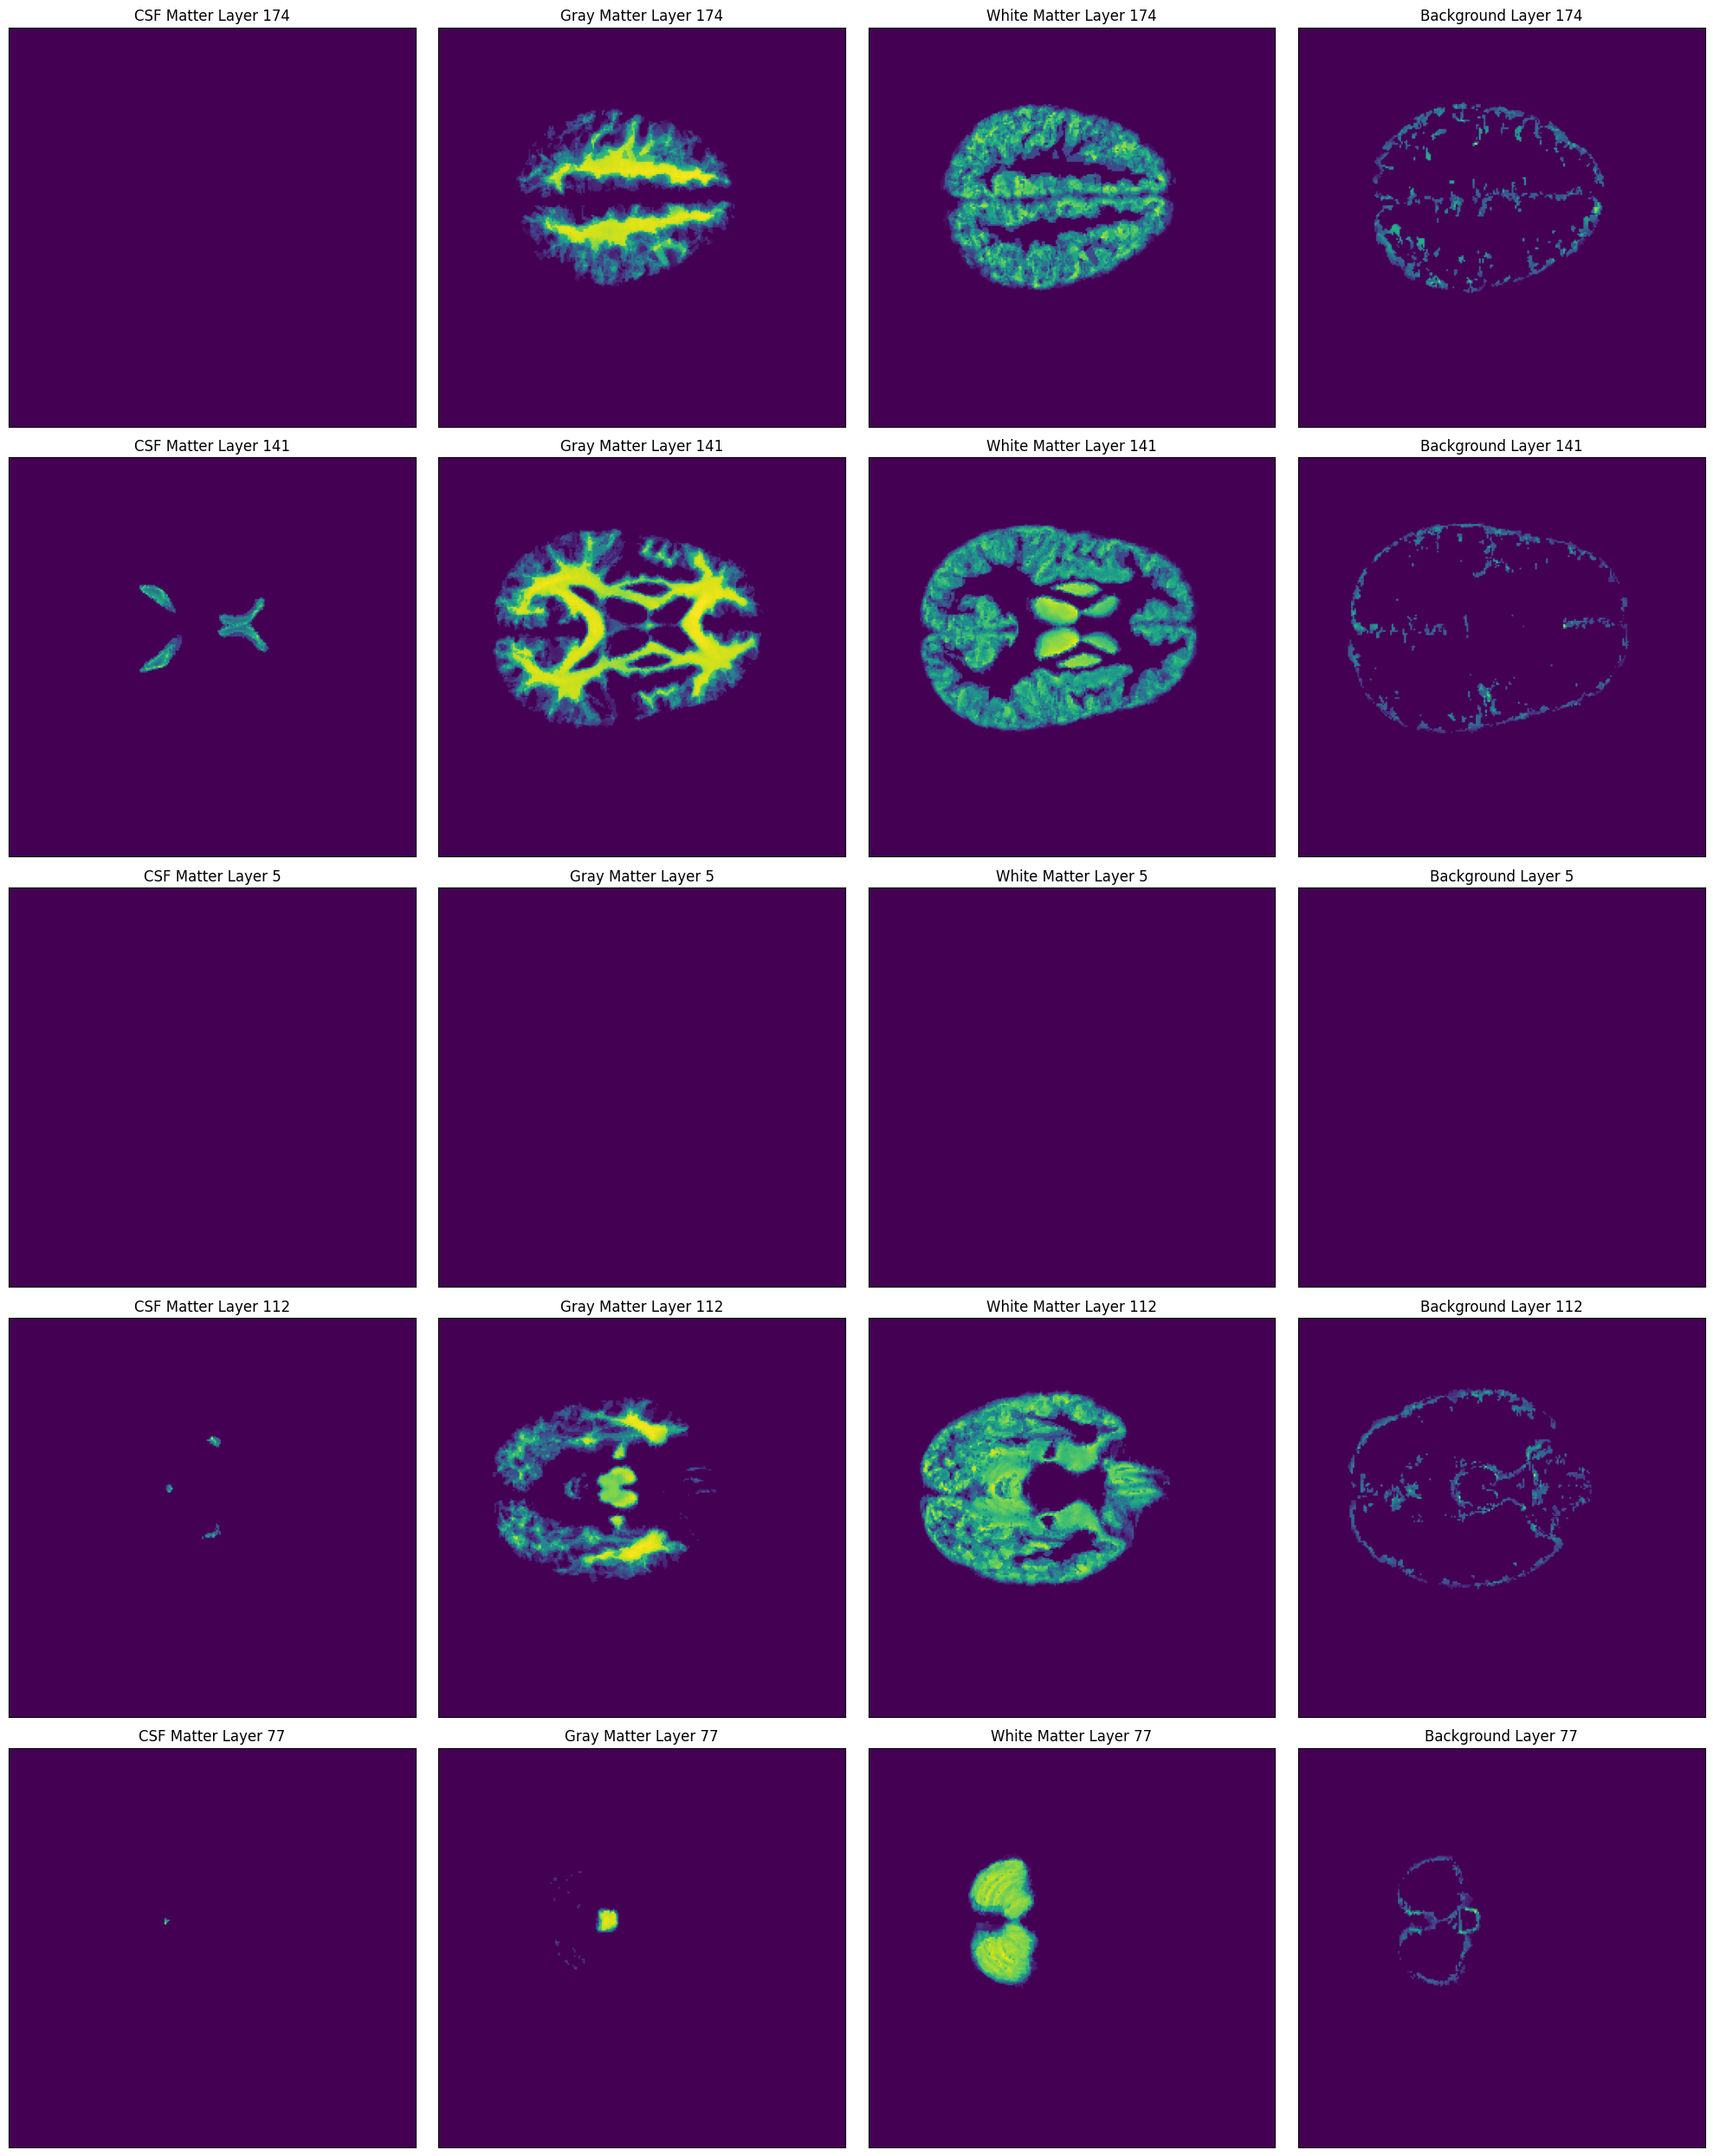

In [21]:

plot_random_brain_layers(prob_cfs_matter, prob_gray_matter, prob_white_matter, prob_bk)


In [19]:
nii_img = nb.Nifti1Image(np.stack([prob_bk,prob_cfs_matter,prob_gray_matter,prob_white_matter],axis=0),None)
output_file = 'atlas.nii.gz'
nii_img.to_filename(output_file)

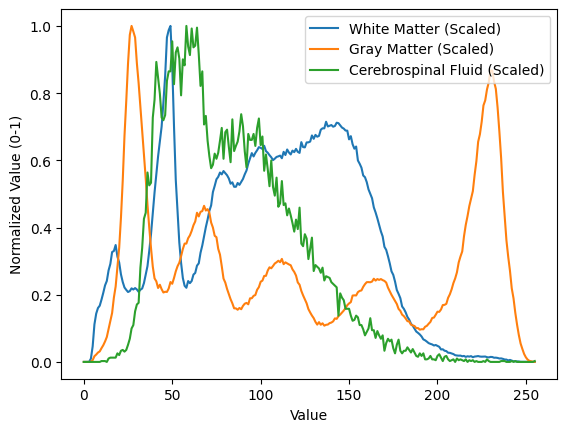

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Example histograms (replace with your own data)
hist_wm, _ = np.histogram(prob_white_matter[prob_white_matter != 0], range=(0, prob_white_matter[prob_white_matter != 0].max()), bins=prob_white_matter[prob_white_matter != 0].max() + 1)
hist_gm, _ = np.histogram(prob_gray_matter[prob_gray_matter != 0], range=(0, prob_gray_matter[prob_gray_matter != 0].max()), bins=prob_gray_matter[prob_gray_matter != 0].max() + 1)
hist_cfs, _ = np.histogram(prob_cfs_matter[prob_cfs_matter != 0], range=(0, prob_cfs_matter[prob_cfs_matter != 0].max()), bins=prob_cfs_matter[prob_cfs_matter != 0].max() + 1)

# Normalize histograms to represent probabilities
hist_wm_prob = hist_wm / hist_wm.sum()
hist_gm_prob = hist_gm / hist_gm.sum()
hist_cfs_prob = hist_cfs / hist_cfs.sum()

# Scale the probability normalized histograms to the [0, 1] range
def scale_to_0_1(hist):
    min_val = hist.min()
    max_val = hist.max()
    scaled_hist = (hist - min_val) / (max_val - min_val)
    return scaled_hist

hist_wm_scaled = scale_to_0_1(hist_wm_prob)
hist_gm_scaled = scale_to_0_1(hist_gm_prob)
hist_cfs_scaled = scale_to_0_1(hist_cfs_prob)

# Create x values for the histogram bins
x_values = np.arange(len(hist_wm_scaled))

# Calculate the x-coordinates of the bar centers
bar_centers = x_values

# Plot the scaled histograms
plt.plot(bar_centers, hist_wm_scaled,label='White Matter (Scaled)')
plt.plot(bar_centers, hist_gm_scaled,label='Gray Matter (Scaled)')
plt.plot(bar_centers, hist_cfs_scaled,label='Cerebrospinal Fluid (Scaled)')

# Set labels and legend
plt.xlabel('Value')
plt.ylabel('Normalized Value (0-1)')
plt.legend()

# Show the plot
plt.show()
